In [28]:
# Imports
import fastf1
import matplotlib as mpl
import matplotlib.pyplot as plt
from fastf1 import plotting
from timple.timedelta import strftimedelta
from fastf1.core import Laps
import pandas as pd
import seaborn as sns

In [29]:
year = 2024 #GP year
gp = 'Bahrain' # GP name
event = 'R' # Q for qualifying, FP1 for free practice 1, R for race

In [30]:
# Configure matplotlib and f1 plots with this intit
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,6)
#fastf1.Cache.enable_cache('\cache')
fastf1.plotting.setup_mpl()
fastf1.plotting.setup_mpl(mpl_timedelta_support = True, color_scheme = 'fastf1', misc_mpl_mods = False)

In [31]:
# Get qualification session
session = fastf1.get_session(year, gp, event)
session.load()
laps = session.laps
#laps.dropna(subset=['Driver'], inplace = True)
box_laps = laps.pick_box_laps()
laps = laps.pick_accurate()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


In [32]:
# Get an array of all drivers
drivers = pd.unique(laps['Driver'])
print(drivers)

# Get each driver fastest lap
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

['VER' 'PER' 'SAI' 'LEC' 'RUS' 'NOR' 'HAM' 'PIA' 'ALO' 'STR' 'ZHO' 'MAG'
 'RIC' 'TSU' 'ALB' 'HUL' 'OCO' 'GAS' 'BOT' 'SAR']


In [33]:
# Get the pole lap
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
fastest_laps['LapTimeDelta'] = fastest_laps['LapTimeDelta'].dt.total_seconds()
#print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])

In [34]:
# Get all team colors
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.team_color(lap['Team'])
    team_colors.append(color)

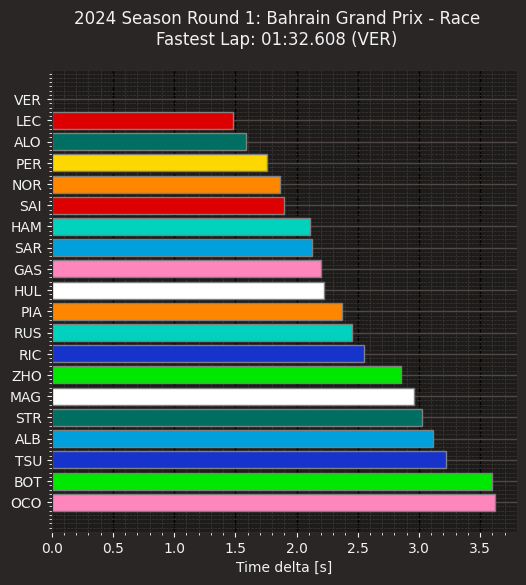

In [35]:
# Plot the table
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'], color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])
ax.invert_yaxis()
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plt.suptitle(f"{session}\n"
f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")
plt.xlabel('Time delta [s]')
plt.show()

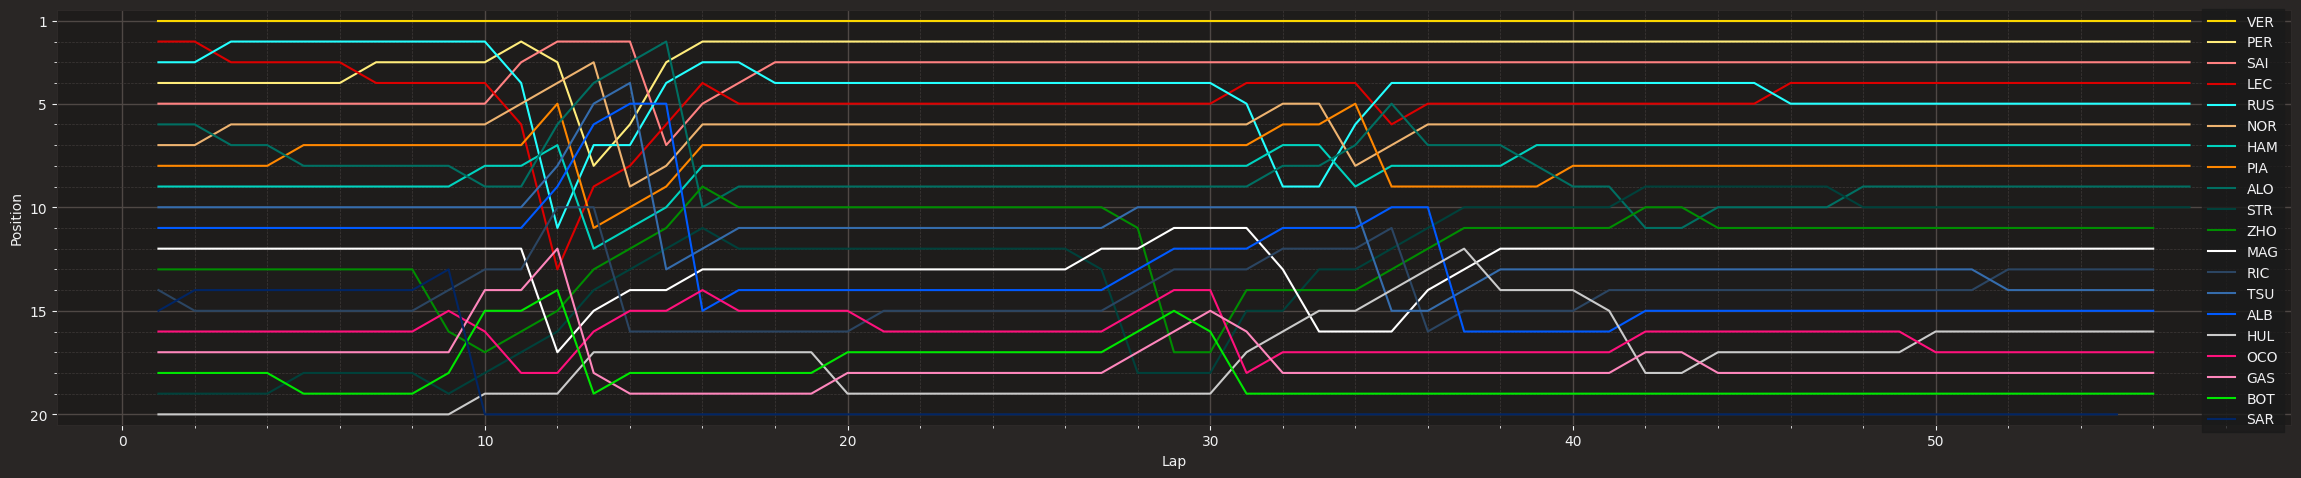

In [36]:
"""
Position changes during a race
==============================

Plot the position of each driver at the end of each lap.
"""


##############################################################################
# Load the session and create the plot

fig, ax = plt.subplots(figsize=(24, 4.9))
# sphinx_gallery_defer_figures

##############################################################################
# For each driver, get their three letter abbreviation (e.g. 'HAM') by simply
# using the value of the first lap, get their color and then plot their
# position over the number of laps.
for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = fastf1.plotting.driver_color(abb)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, color=color)
# sphinx_gallery_defer_figures

##############################################################################
# Finalize the plot by setting y-limits that invert the y-axis so that position
# one is at the top, set custom tick positions and axis labels.
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')
# sphinx_gallery_defer_figures

##############################################################################
# Because this plot is very crowed, add the legend outside the plot area.
ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

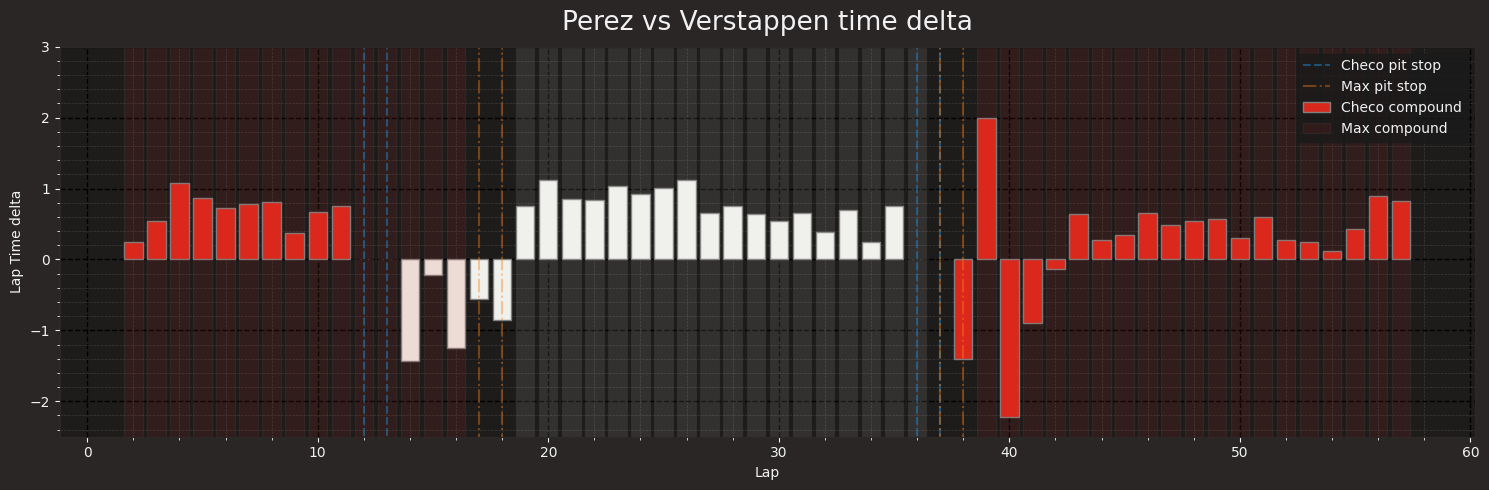

In [67]:
per = laps.pick_driver("PER").reset_index()
ver = laps.pick_driver('VER').reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x=per['LapNumber'], height=(per['LapTime']-ver_time['LapTime']).dt.total_seconds(), color=per['Compound'].map(fastf1.plotting.COMPOUND_COLORS), edgecolor='grey', label='Checo compound')
ax.bar(x=ver['LapNumber'], height=-5, color=ver['Compound'].map(fastf1.plotting.COMPOUND_COLORS), alpha=0.1, edgecolor='grey', label='Max compound')
ax.bar(x=ver['LapNumber'], height=5, color=ver['Compound'].map(fastf1.plotting.COMPOUND_COLORS), alpha=0.1, edgecolor='grey')
plt.vlines(x=box_laps.pick_driver('PER').reset_index()['LapNumber'], ymin=-10, ymax=10, color='tab:blue', linestyles='dashed', alpha=0.6, label='Checo pit stop')
plt.vlines(x=box_laps.pick_driver('VER').reset_index()['LapNumber'], ymin=-10, ymax=10, color='tab:orange', linestyles='dashdot', alpha=0.4, label='Max pit stop')
ax.set_xlabel('Lap')
ax.set_ylabel('Lap Time delta')
ax.set_title('Perez vs Verstappen time delta')
plt.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
#ax.set_yticks([-2, -1, 0, 1, 2])
plt.ylim(-2.5, 3)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
perez

,index,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,58,0 days 01:03:16.820000,PER,11,0 days 00:01:36.541000,2.0,1.0,NaT,NaT,0 days 00:00:30.678000,...,False,Red Bull Racing,0 days 01:01:40.279000,2024-03-02 15:05:22.710,1,4.0,False,,False,True
1,59,0 days 01:04:54.117000,PER,11,0 days 00:01:37.297000,3.0,1.0,NaT,NaT,0 days 00:00:30.596000,...,False,Red Bull Racing,0 days 01:03:16.820000,2024-03-02 15:06:59.251,1,4.0,False,,False,True
2,60,0 days 01:06:31.839000,PER,11,0 days 00:01:37.722000,4.0,1.0,NaT,NaT,0 days 00:00:30.716000,...,False,Red Bull Racing,0 days 01:04:54.117000,2024-03-02 15:08:36.548,1,4.0,False,,False,True
3,61,0 days 01:08:09.883000,PER,11,0 days 00:01:38.044000,5.0,1.0,NaT,NaT,0 days 00:00:30.997000,...,False,Red Bull Racing,0 days 01:06:31.839000,2024-03-02 15:10:14.270,1,4.0,False,,False,True
4,62,0 days 01:09:47.706000,PER,11,0 days 00:01:37.823000,6.0,1.0,NaT,NaT,0 days 00:00:30.843000,...,False,Red Bull Racing,0 days 01:08:09.883000,2024-03-02 15:11:52.314,1,4.0,False,,False,True
5,63,0 days 01:11:25.527000,PER,11,0 days 00:01:37.821000,7.0,1.0,NaT,NaT,0 days 00:00:31.013000,...,False,Red Bull Racing,0 days 01:09:47.706000,2024-03-02 15:13:30.137,1,3.0,False,,False,True
6,64,0 days 01:13:03.365000,PER,11,0 days 00:01:37.838000,8.0,1.0,NaT,NaT,0 days 00:00:31.305000,...,False,Red Bull Racing,0 days 01:11:25.527000,2024-03-02 15:15:07.958,1,3.0,False,,False,True
7,65,0 days 01:14:40.961000,PER,11,0 days 00:01:37.596000,9.0,1.0,NaT,NaT,0 days 00:00:31.145000,...,False,Red Bull Racing,0 days 01:13:03.365000,2024-03-02 15:16:45.796,1,3.0,False,,False,True
8,66,0 days 01:16:18.591000,PER,11,0 days 00:01:37.630000,10.0,1.0,NaT,NaT,0 days 00:00:31.178000,...,False,Red Bull Racing,0 days 01:14:40.961000,2024-03-02 15:18:23.392,2,3.0,False,,False,True
9,67,0 days 01:17:56.427000,PER,11,0 days 00:01:37.836000,11.0,1.0,NaT,NaT,0 days 00:00:31.054000,...,False,Red Bull Racing,0 days 01:16:18.591000,2024-03-02 15:20:01.022,1,2.0,False,,False,True
